In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.datasets import AmazonProducts
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
dataset = AmazonProducts(root='AmazonProducts')

In [4]:
data = dataset[0]

In [5]:
data

Data(x=[1569960, 200], edge_index=[2, 264339468], y=[1569960, 107], train_mask=[1569960], val_mask=[1569960], test_mask=[1569960])

In [6]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Graph: {data}')

Number of nodes: 1569960
Number of edges: 264339468
Number of features per node: 200
Number of classes: 107
Graph: Data(x=[1569960, 200], edge_index=[2, 264339468], y=[1569960, 107], train_mask=[1569960], val_mask=[1569960], test_mask=[1569960])


In [18]:
dataset.x.shape

torch.Size([1569960, 200])

In [22]:
import torch
from torch_geometric.datasets import AmazonProducts
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborSampler

# Load dataset
dataset = AmazonProducts(root='AmazonProducts')
data = dataset[0]

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 64)
        self.conv2 = GCNConv(64, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Define training function
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch_size, n_id, adj in loader:
        # Load data to device
        adj = adj.to(device)
        x = data.x[n_id].to(device)
        y = data.y[n_id[:batch_size]].to(device)

        # Forward pass
        out = model(x, adj.edge_index)[:batch_size]
        loss = F.cross_entropy(out, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

# Define evaluation function
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    for batch_size, n_id, adj in loader:
        adj = adj.to(device)
        x = data.x[n_id].to(device)
        y = data.y[n_id[:batch_size]].to(device)

        out = model(x, adj.edge_index)[:batch_size]
        pred = out.argmax(dim=1)
        correct += int((pred == y).sum())

    return correct / len(loader.dataset)

# Initialize model, optimizer, and NeighborSampler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(dataset.num_features, dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loader = NeighborSampler(data.edge_index, node_idx=None, sizes=[-1],
                         batch_size=1024, shuffle=True,
                         num_workers=12)

# Train and evaluate
for epoch in range(1, 201):
    loss = train(model, loader, optimizer, device)
    acc = evaluate(model, loader, device)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

In [43]:
data.edge_index

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [41]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

Number of nodes: 34
Number of edges: 156
Number of features per node: 34


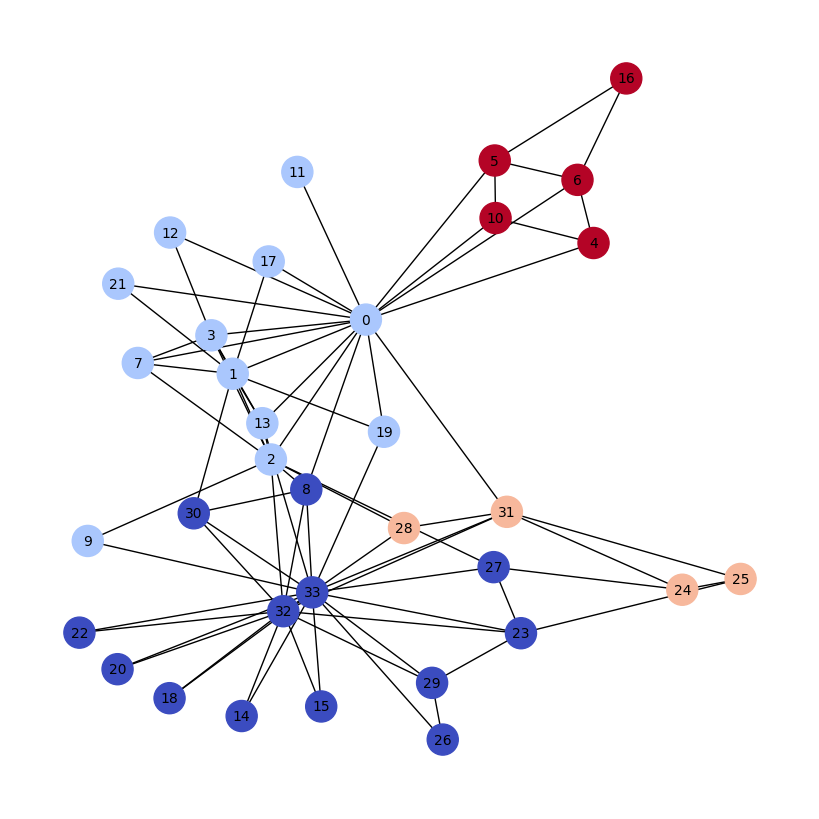

In [40]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

# Load the Karate Club dataset
dataset = KarateClub()
data = dataset[0]

# Print basic dataset information
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')

# Convert the PyTorch Geometric data to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Plot the graph
plt.figure(figsize=(8, 8))

# Draw the nodes, coloring them by their label (faction)
node_color = [data.y[i].item() for i in range(data.num_nodes)]
pos = nx.spring_layout(G, seed=42)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, node_color=node_color, cmap=plt.get_cmap('coolwarm'), node_size=500, font_size=10)

plt.show()


In [26]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader

# Load the dataset
dataset = KarateClub()
data = dataset[0]

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
accuracy = correct / int(data.test_mask.sum())
print(f'Accuracy: {accuracy:.4f}')


Epoch 1, Loss: 1.4171257019042969
Epoch 2, Loss: 1.4085125923156738
Epoch 3, Loss: 1.3883171081542969
Epoch 4, Loss: 1.3669211864471436
Epoch 5, Loss: 1.3490164279937744
Epoch 6, Loss: 1.3400508165359497
Epoch 7, Loss: 1.30966317653656
Epoch 8, Loss: 1.3016620874404907
Epoch 9, Loss: 1.3109846115112305
Epoch 10, Loss: 1.2612330913543701
Epoch 11, Loss: 1.2630250453948975
Epoch 12, Loss: 1.2282779216766357
Epoch 13, Loss: 1.2407352924346924
Epoch 14, Loss: 1.206752896308899
Epoch 15, Loss: 1.2291347980499268
Epoch 16, Loss: 1.1804240942001343
Epoch 17, Loss: 1.1485536098480225
Epoch 18, Loss: 1.1326699256896973
Epoch 19, Loss: 1.11868417263031
Epoch 20, Loss: 1.115434169769287
Epoch 21, Loss: 1.0675427913665771
Epoch 22, Loss: 1.0523335933685303
Epoch 23, Loss: 0.9861679077148438
Epoch 24, Loss: 1.0039722919464111
Epoch 25, Loss: 0.9735748171806335
Epoch 26, Loss: 0.9564861059188843
Epoch 27, Loss: 0.8793660998344421
Epoch 28, Loss: 0.881402850151062
Epoch 29, Loss: 0.7417420148849487
E

AttributeError: 'GlobalStorage' object has no attribute 'test_mask'

In [27]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='Cora', name='Cora')

Processing...
Done!


In [33]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of features per node: {data.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Graph: {data}')

Number of nodes: 2708
Number of edges: 10556
Number of features per node: 1433
Number of classes: 7
Graph: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [38]:
data.test_mask

tensor([False, False, False,  ...,  True,  True,  True], device='cuda:0')

In [29]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7950


In [12]:
data.num_features

165

In [9]:
data.train_mask.sum()

tensor(29894, device='cuda:0')

In [10]:
data.test_mask.sum()

tensor(16670, device='cuda:0')

In [36]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import EllipticBitcoinDataset
from sklearn.metrics import classification_report

root = 'EllipticBitcoin'
dataset = EllipticBitcoinDataset(root)

data = dataset[0]

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=dataset.num_features, hidden_channels=100, out_channels=2).to(device)
data = data.to(device)
class_weights = torch.tensor([0.3, 0.7]).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    _, pred = out.max(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc, pred

for epoch in range(1, 1001):
    loss = train()
    if epoch % 100 == 0:
        acc, _ = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# Evaluate the model
acc, pred = test()
print(f'Test Accuracy: {acc:.4f}')

# Generate a classification report
y_true = data.y[data.test_mask].cpu()
y_pred = pred[data.test_mask].cpu()
print(classification_report(y_true, y_pred, target_names=['licit', 'illicit']))


Epoch: 100, Loss: 0.2576, Test Accuracy: 0.8132
Epoch: 200, Loss: 0.2120, Test Accuracy: 0.8972
Epoch: 300, Loss: 0.1838, Test Accuracy: 0.9328
Epoch: 400, Loss: 0.1700, Test Accuracy: 0.9410
Epoch: 500, Loss: 0.1600, Test Accuracy: 0.9415
Epoch: 600, Loss: 0.1491, Test Accuracy: 0.9436
Epoch: 700, Loss: 0.1434, Test Accuracy: 0.9445
Epoch: 800, Loss: 0.1370, Test Accuracy: 0.9448
Epoch: 900, Loss: 0.1317, Test Accuracy: 0.9452
Epoch: 1000, Loss: 0.1264, Test Accuracy: 0.9451
Test Accuracy: 0.9451
              precision    recall  f1-score   support

       licit       0.96      0.98      0.97     15587
     illicit       0.61      0.44      0.51      1083

    accuracy                           0.95     16670
   macro avg       0.78      0.71      0.74     16670
weighted avg       0.94      0.95      0.94     16670



: 

In [10]:
import uuid

# Generate a UUID and remove dashes to make it URL-friendly
unique_id = uuid.uuid4().hex
print(unique_id)

a557d56867de446ea3d17389ed9c1edd


In [11]:
import random
import secrets
from statistics import mean
from statistics import stdev
import string
import time
import timeit
import uuid

import shortuuid


alphabet = string.ascii_lowercase + string.digits
su = shortuuid.ShortUUID(alphabet=alphabet)


def random_choice():
    return ''.join(random.choices(alphabet, k=8))


def truncated_uuid4():
    return str(uuid.uuid4())[:8]


def shortuuid_random():
    return su.random(length=8)


def secrets_random_choice():
    return ''.join(secrets.choice(alphabet) for _ in range(8))


def test_collisions(fun):
    out = set()
    count = 0
    for _ in range(10_000_000):
        new = fun()
        if new in out:
            count += 1
        else:
            out.add(new)
    return count


def run_and_print_results(fun):
    round_digits = 5
    now = time.time()
    collisions = test_collisions(fun)
    total_time = round(time.time() - now, round_digits)

    trials = 1_000
    runs = 100
    func_time = timeit.repeat(fun, repeat=runs, number=trials)
    avg = round(mean(func_time), round_digits)
    std = round(stdev(func_time), round_digits)

    print(f'{fun.__name__}: collisions {collisions} - '
          f'time (s) {avg} ± {std} - '
          f'total (s) {total_time}')


if __name__ == '__main__':
    run_and_print_results(random_choice)
    run_and_print_results(truncated_uuid4)
    run_and_print_results(shortuuid_random)
    run_and_print_results(secrets_random_choice)

ModuleNotFoundError: No module named 'shortuuid'